<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales/blob/main/algoritmo_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Algoritmo de Gillespie

Nombre: Biología de sistemas UNAM

Fecha: diciembre 2021

In [1]:
# importar librerías 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint

## Descripción del proceso (en este caso, las reacciones): 
El sistema bioquímico de formación y degradación de la GFP a considerar en está dado por las reacciones representadas por:

$$
\varnothing \xrightarrow[]{k_1} \text{GFP} \xrightarrow[]{k_2}  \varnothing \tag{1}
$$

# 1. Establecer modelo y obtener estado estacionario 

## Red para describir las reacciones en las que participa la GFP

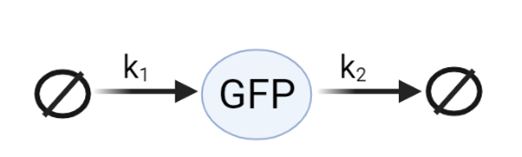

## Modelo matemático 

Realizando el balance de materia para la proteína GFP se tiene

$$
\text{cambio de concentración de la GFP} = \text{entrada de GFP} - \text{degradación de GFP} \tag{2}
$$

$$
\frac{dGFP}{dt} = k_1 s - k_2 GFP \tag{3} 
$$

En (3) se supone que la producción de GFP se realiza a una velocidad constante. Por otro lado, la degradación de la GFP se establece proporcional a su concentración.

Dado que el primer término en (3) es una constante se puede escribir como 

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP \tag{4}
$$

donde $p_1 = k_1 s$

## Análisis de estabilidad 

Igualando (4) a cero y despejando de obtiene el estado estacionario.

$$
\frac{dGFP}{dt} = p_1 - k_2 GFP = 0 \rightarrow GFP_{ss} = \frac{p_1}{k_2}
$$

In [2]:
# estado estacionario 
def estado_estacionario(p1, k2):
    return p1 / k2

In [4]:
p1 = 1
k2 = 1
ss = estado_estacionario(p1, k2)
print(ss)

1.0


# Algoritmo de Gillespie 

Primero es necesario establecer una función que nos permita calcular las velocidades de reacción en cada instante 


In [5]:
# función para calcular las tasas de generación y degradación
def tasas(GFP): 
    return [p1, k2*GFP]

In [10]:
# función para implementar el algoritmo 
def gillespieGFp(GFP0, rate_const, get_rates, tend):

    tvec = np.zeros((1,)) # vector para guardar los tiempos en los que ocurren las rxs

    GFPvec = np.zeros((1,)) # vector para guardar los valores de GFP en el tiempo

    tvec[0] = 0 # tiempo inicial 

    GFPvec[0] = GFP0 # GFP inicial 

    return [tvec, GFPvec]

    while tvec[-1] < tend): # mientras el último valor de tiempo sea menor a tend
        current_GFP = GFPvec[-1] # valor actual de GFP
        tasas = tasas(current_GFP) # calcular velocidades de reacción
        suma_tasa = np.sum(tasas)

        tau = rexp(1, rate_sum) # tomar el paso de tiempo de una función de distribución exponencial 

        tvec = c(tvec, tvec[length(tvec)] + tau) # nuevo tiempo en el que ocurre la rx

        rx = sample(length(rates), 1, prob = rates) # seleccionar la rxs que ocurrirá con una probabilidad 
        # propoorcional a su velocidad 

        # actualizar valor de GFP
        if (rx == 1) {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] + 1) # producción
        }
        else {
            GFPvec = c(GFPvec, GFPvec[length(GFPvec)] - 1) # degradación
        }
    }
    return(list(t = tvec, GFP = GFPvec))

}

3

In [9]:
gillespieGFp(0, 1, 1, 1)

[array([0.]), array([0.])]

In [14]:
x = np.random.exponential( )

print(x)

1.3561799798601826
